In [ ]:
import torch
from torch.nn import functional as F
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.auto import tqdm


%matplotlib inline

# set seed for replicable results
torch.manual_seed(999)
random.seed(10)

In [ ]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torch.utils.data import DataLoader

# Ayarlar
image_path = "/content/drive/MyDrive/Abstract_gallery"
image_size = (64, 64)
batch_size = 32
latent_size = 100
epoch_restore = 150
checkpoint_path = f"/content/{epoch_restore}epochs.chkpt"  # Manuel olarak yüklenen checkpoint dosyası

lr = 0.0002
beta1 = 0.5
epochs = 10

# Görselleri okuma ve ön işleme
dataset = ImageFolder(root=image_path,
                      transform=T.Compose([
                          T.Resize(image_size),
                          T.ToTensor(),
                          T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # [-1, 1] aralığına normalize et
                      ]))

# Dataloader oluşturma
dataloader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=True, num_workers=2)

In [ ]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")

In [ ]:
# getting a batch from the dataloader
batch = next(iter(dataloader))

# Visualize our training images

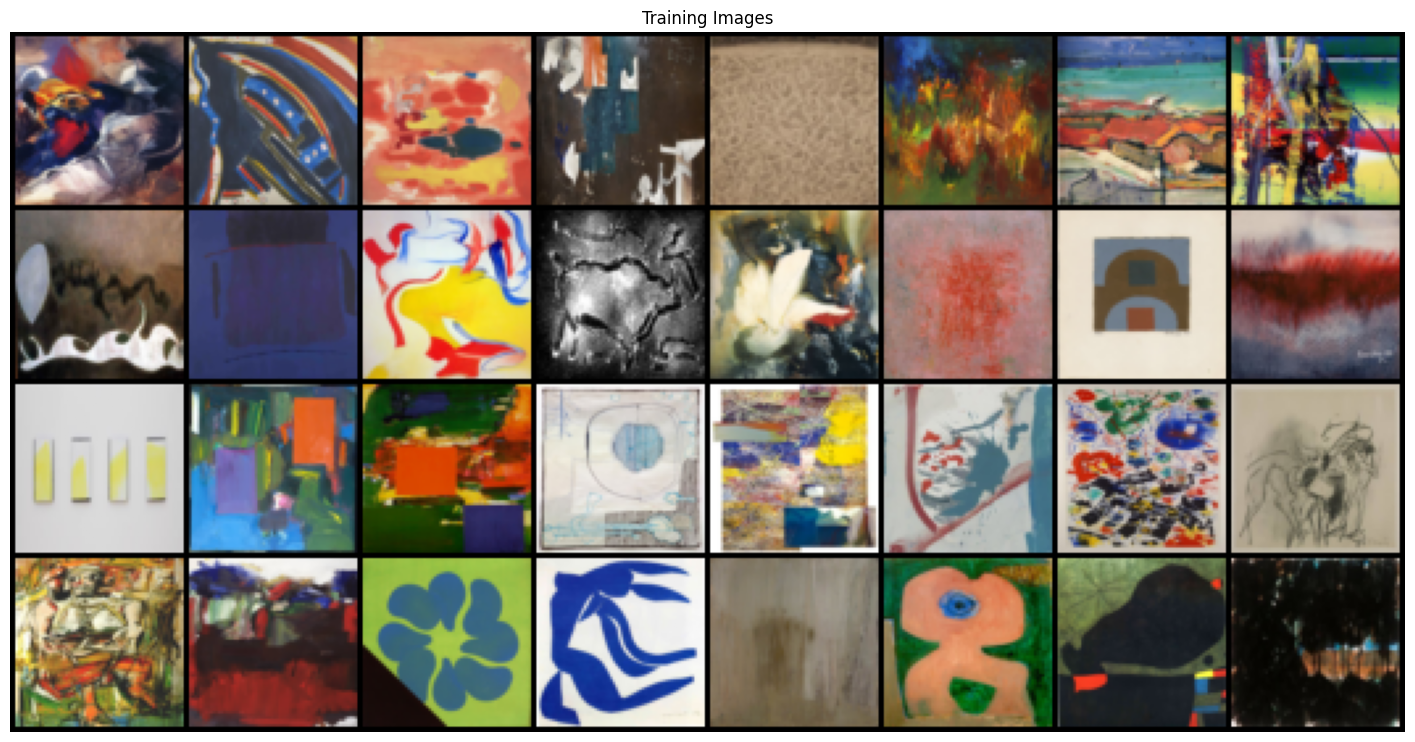

In [ ]:
plt.figure(figsize=(18,18))
plt.axis("off")
plt.title("Training Images")

# viewing the training data
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

# DCGAN Generator Architecture

In [ ]:
# custom weights initialization based on the 2015 DCGAN paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

![](https://pytorch.org/tutorials/_images/dcgan_generator.png)

# Generator architecture

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.conv1 = nn.ConvTranspose2d(latent_size, 64*8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(64*8)
        self.conv2 = nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv3 = nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*2)
        self.conv4 = nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        return torch.tanh(self.conv5(x))

In [ ]:
generator = Generator().to(device)
generator.apply(weights_init)

# calculate the trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(generator)
print("Trainable Parameters:", count_parameters(generator))

Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Trainable Parameters: 3576704


Let's see what we get without training the generator

In [ ]:
untrained_output = generator(torch.randn(1, 100, 1, 1, device=device))
print(untrained_output.shape)

torch.Size([1, 3, 64, 64])


# Discriminator architecture

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64*2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64*2)
        self.conv3 = nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv4 = nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*8)
        self.conv5 = nn.Conv2d(64*8, 1, 4, 1, 0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv4(x)), negative_slope=0.2, inplace=True)
        return torch.sigmoid(self.conv5(x))

In [ ]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

print(discriminator)
print("Trainable Parameters:", count_parameters(discriminator))

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
Trainable Parameters: 2765568


Let's see what we get without training the discriminator

In [ ]:
discriminator(untrained_output).view(-1).detach()

tensor([0.4306], device='cuda:0')

In [ ]:
# cross binary entropy
criterion = nn.BCELoss()
sampled_noise  = torch.randn(batch_size, latent_size, 1, 1, device=device)

# real is 1 and fake is 0
real_label = 1
fake_label = 0

generator_optim = Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
discriminator_optim = Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# restore to the latest checkpoint

checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
generator_optim.load_state_dict(checkpoint['generator_optim_state_dict'])
discriminator_optim.load_state_dict(checkpoint['discriminator_optim_state_dict'])

# Training the GAN

In [ ]:
generator_loss = []
discriminator_loss = []
iters = 0
img_list = []

In [ ]:
for epoch in range(epochs):
    for i, data in enumerate(tqdm(dataloader)):

        # train the discriminator
        discriminator.zero_grad()
        real_data = data[0].to(device)
        real_size = real_data.size(0)

        # [1, 1, 1, 1...., 1]
        label = torch.ones(real_size, dtype=torch.float32, device=device)

        output = discriminator(real_data).view(-1)
        # loss on all-real batch
        error_real_batch = criterion(output, label)

        # calculate the derivative wrt parameters
        error_real_batch.backward()
        D_x = output.mean().item()

        # generating fake data
        noise = torch.randn(real_size, latent_size, 1, 1, device=device)
        fake_data = generator(noise)

        # change the label to [0, 0, 0, 0....., 0]
        label.fill_(fake_label)

        # classify all fake batch with discriminator
        output = discriminator(fake_data.detach()).view(-1)
        error_fake_batch = criterion(output, label)
        error_fake_batch.backward()

        # the sum of the discriminator
        error_discriminator = error_real_batch + error_fake_batch
        discriminator_optim.step()

        # train the generator
        generator.zero_grad()
        # pretend the generated results are real
        label.fill_(real_label)

        output = discriminator(fake_data).view(-1)
        error_generator = criterion(output, label)
        error_generator.backward()
        generator_optim.step()

        # print out summary statistics
        if i % 10 == 0:
            tqdm.write('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     error_discriminator.item(), error_generator.item()))

        discriminator_loss.append(error_discriminator.item())
        generator_loss.append(error_generator.item())

         # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fakes = generator(sampled_noise).detach().cpu()
            img_list.append(vutils.make_grid(fakes, padding=2, normalize=True))

        iters += 1


  0%|          | 0/87 [00:00<?, ?it/s]

[0/10][0/87]	Loss_D: 0.0824	Loss_G: 6.0895
[0/10][10/87]	Loss_D: 0.0756	Loss_G: 5.1028
[0/10][20/87]	Loss_D: 0.1240	Loss_G: 4.3707
[0/10][30/87]	Loss_D: 0.0899	Loss_G: 4.8029
[0/10][40/87]	Loss_D: 0.0863	Loss_G: 4.9572
[0/10][50/87]	Loss_D: 0.1514	Loss_G: 5.9139
[0/10][60/87]	Loss_D: 0.0636	Loss_G: 7.2089
[0/10][70/87]	Loss_D: 0.0618	Loss_G: 6.5315
[0/10][80/87]	Loss_D: 0.1345	Loss_G: 5.1376


  0%|          | 0/87 [00:00<?, ?it/s]

[1/10][0/87]	Loss_D: 0.0718	Loss_G: 5.8779


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db4706a7920>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db4706a7920>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

[1/10][10/87]	Loss_D: 0.0205	Loss_G: 5.9278
[1/10][20/87]	Loss_D: 0.0331	Loss_G: 5.6915
[1/10][30/87]	Loss_D: 0.1017	Loss_G: 5.9838
[1/10][40/87]	Loss_D: 0.1383	Loss_G: 5.1591
[1/10][50/87]	Loss_D: 0.0949	Loss_G: 4.9937
[1/10][60/87]	Loss_D: 0.0958	Loss_G: 5.8112
[1/10][70/87]	Loss_D: 0.0415	Loss_G: 6.4661
[1/10][80/87]	Loss_D: 0.1249	Loss_G: 4.6828


  0%|          | 0/87 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db4706a7920>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
        Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7db4706a7920> 
 Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^^    ^if w.is_alive():^^^^^^^^
^^^  ^^^   ^  ^^^^^^

[2/10][0/87]	Loss_D: 0.0378	Loss_G: 6.6334
[2/10][10/87]	Loss_D: 0.0751	Loss_G: 5.1634
[2/10][20/87]	Loss_D: 0.0603	Loss_G: 5.8866
[2/10][30/87]	Loss_D: 0.0832	Loss_G: 5.0456
[2/10][40/87]	Loss_D: 0.1330	Loss_G: 6.4178
[2/10][50/87]	Loss_D: 0.0360	Loss_G: 5.9258
[2/10][60/87]	Loss_D: 0.1214	Loss_G: 6.0145
[2/10][70/87]	Loss_D: 0.0386	Loss_G: 6.0079
[2/10][80/87]	Loss_D: 0.0578	Loss_G: 5.9037


  0%|          | 0/87 [00:00<?, ?it/s]

[3/10][0/87]	Loss_D: 0.0479	Loss_G: 5.3936
[3/10][10/87]	Loss_D: 0.2667	Loss_G: 4.2789
[3/10][20/87]	Loss_D: 0.0910	Loss_G: 6.8984
[3/10][30/87]	Loss_D: 0.1682	Loss_G: 5.5310
[3/10][40/87]	Loss_D: 0.0689	Loss_G: 5.5977
[3/10][50/87]	Loss_D: 0.1602	Loss_G: 4.5914
[3/10][60/87]	Loss_D: 0.0657	Loss_G: 6.2372
[3/10][70/87]	Loss_D: 0.0726	Loss_G: 6.1993
[3/10][80/87]	Loss_D: 0.0383	Loss_G: 5.7672


  0%|          | 0/87 [00:00<?, ?it/s]

[4/10][0/87]	Loss_D: 0.3358	Loss_G: 6.8767
[4/10][10/87]	Loss_D: 0.0695	Loss_G: 5.7904
[4/10][20/87]	Loss_D: 0.0209	Loss_G: 6.2171
[4/10][30/87]	Loss_D: 0.1281	Loss_G: 5.8197
[4/10][40/87]	Loss_D: 0.0867	Loss_G: 5.7834
[4/10][50/87]	Loss_D: 0.0687	Loss_G: 6.4648
[4/10][60/87]	Loss_D: 0.0564	Loss_G: 5.8113
[4/10][70/87]	Loss_D: 0.1379	Loss_G: 7.6158
[4/10][80/87]	Loss_D: 0.1451	Loss_G: 6.0929


  0%|          | 0/87 [00:00<?, ?it/s]

[5/10][0/87]	Loss_D: 0.0718	Loss_G: 6.4646
[5/10][10/87]	Loss_D: 0.1037	Loss_G: 4.6122
[5/10][20/87]	Loss_D: 0.0362	Loss_G: 6.1165
[5/10][30/87]	Loss_D: 0.0450	Loss_G: 5.8242
[5/10][40/87]	Loss_D: 0.0245	Loss_G: 5.7076
[5/10][50/87]	Loss_D: 0.0334	Loss_G: 6.7150
[5/10][60/87]	Loss_D: 0.0614	Loss_G: 6.5077
[5/10][70/87]	Loss_D: 0.1361	Loss_G: 7.3867
[5/10][80/87]	Loss_D: 0.0559	Loss_G: 6.2216


  0%|          | 0/87 [00:00<?, ?it/s]

[6/10][0/87]	Loss_D: 0.1014	Loss_G: 5.2827
[6/10][10/87]	Loss_D: 0.0578	Loss_G: 5.4872
[6/10][20/87]	Loss_D: 0.0517	Loss_G: 5.4780
[6/10][30/87]	Loss_D: 0.0188	Loss_G: 5.5884
[6/10][40/87]	Loss_D: 0.0147	Loss_G: 6.8541
[6/10][50/87]	Loss_D: 0.0270	Loss_G: 6.1972
[6/10][60/87]	Loss_D: 0.0464	Loss_G: 6.5140
[6/10][70/87]	Loss_D: 0.3920	Loss_G: 3.8828
[6/10][80/87]	Loss_D: 0.0288	Loss_G: 7.4882


  0%|          | 0/87 [00:00<?, ?it/s]

[7/10][0/87]	Loss_D: 0.1123	Loss_G: 6.7727
[7/10][10/87]	Loss_D: 0.0870	Loss_G: 7.2011
[7/10][20/87]	Loss_D: 0.0645	Loss_G: 6.2023
[7/10][30/87]	Loss_D: 0.0506	Loss_G: 5.3964
[7/10][40/87]	Loss_D: 0.0534	Loss_G: 6.7430
[7/10][50/87]	Loss_D: 0.1036	Loss_G: 6.4833
[7/10][60/87]	Loss_D: 0.0305	Loss_G: 7.8639
[7/10][70/87]	Loss_D: 0.0623	Loss_G: 5.7271
[7/10][80/87]	Loss_D: 0.0577	Loss_G: 6.2025


  0%|          | 0/87 [00:00<?, ?it/s]

[8/10][0/87]	Loss_D: 0.1158	Loss_G: 4.5629
[8/10][10/87]	Loss_D: 0.2637	Loss_G: 5.2816
[8/10][20/87]	Loss_D: 0.0285	Loss_G: 5.7777
[8/10][30/87]	Loss_D: 0.1606	Loss_G: 8.2782
[8/10][40/87]	Loss_D: 0.0360	Loss_G: 6.1684
[8/10][50/87]	Loss_D: 0.0310	Loss_G: 6.1093
[8/10][60/87]	Loss_D: 0.1447	Loss_G: 4.8309
[8/10][70/87]	Loss_D: 0.1146	Loss_G: 5.9679
[8/10][80/87]	Loss_D: 0.0357	Loss_G: 6.2321


  0%|          | 0/87 [00:00<?, ?it/s]

[9/10][0/87]	Loss_D: 0.0386	Loss_G: 6.6941
[9/10][10/87]	Loss_D: 4.6680	Loss_G: 1.0914
[9/10][20/87]	Loss_D: 0.5672	Loss_G: 5.3843
[9/10][30/87]	Loss_D: 0.4879	Loss_G: 7.9878
[9/10][40/87]	Loss_D: 2.4330	Loss_G: 14.5650
[9/10][50/87]	Loss_D: 0.6054	Loss_G: 5.6216
[9/10][60/87]	Loss_D: 0.1521	Loss_G: 4.8591
[9/10][70/87]	Loss_D: 0.7070	Loss_G: 3.7701
[9/10][80/87]	Loss_D: 0.3608	Loss_G: 4.7347


# Training statistics

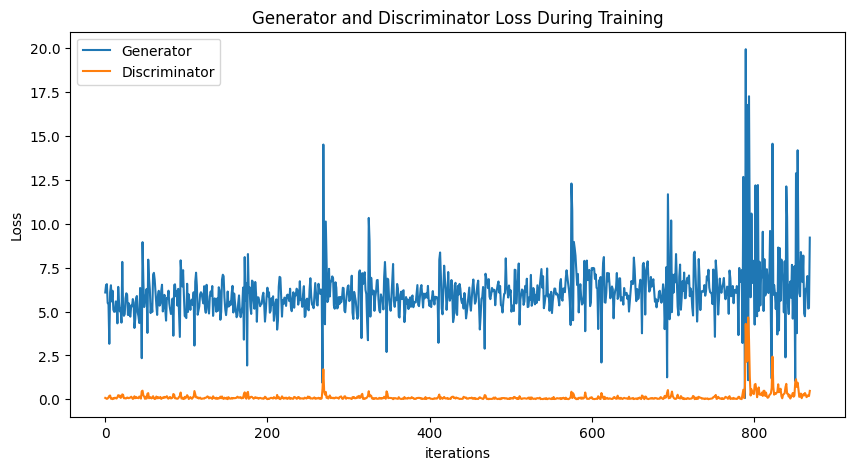

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_loss,label="Generator")
plt.plot(discriminator_loss,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# GIF visualization

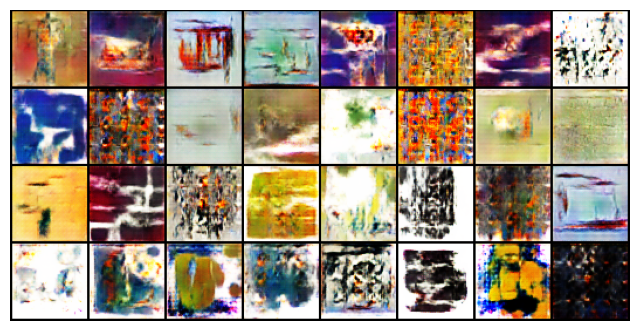

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=300, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Save model

In [ ]:
end_epoch = epoch_restore + epochs
save_file = "{}epochs.chkpt".format(end_epoch)

torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'generator_optim_state_dict' : generator_optim.state_dict(),
            'discriminator_optim_state_dict' : discriminator_optim.state_dict(),}, save_file)